This project aims to create two classification models for political social media posts. The first will be a binary classifier to predict whether the posts are partisan or neutral. The second will be a multiclass model that predicts the overall message category of a post. We'll use the Political Social Media Posts dataset on Kaggle, which contains Facebook and Twitter posts from politicians' accounts, as well as human-labeled variables such as the post's bias and substance of its message. Posts were collected from the year 2015. The ability to classify the bias and message of politicians' posts can help constituents, political organizations, and research institutions better understand their political views. All dependencies for the project are imported below.

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
from imblearn.over_sampling import SMOTE
from wordcloud import WordCloud, STOPWORDS
import numpy as np
from collections import Counter
import tweepy
import re
import string
import imblearn
import joblib

import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer 
from nltk.collocations import *
from nltk import FreqDist
from nltk.probability import FreqDist


from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV 
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

Exploring and Preprocessing the Data

Let's read in and preview the data:

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/political_social_media.csv', encoding='latin1')

In [ ]:

df.head()

,_unit_id,_golden,_unit_state,_trusted_judgments,_last_judgment_at,audience,audience:confidence,bias,bias:confidence,message,...,orig__golden,audience_gold,bias_gold,bioid,embed,id,label,message_gold,source,text
0,766192484,False,finalized,1,8/4/15 21:17,national,1.0,partisan,1.0,policy,...,NaN,NaN,NaN,R000596,"<blockquote class=""twitter-tweet"" width=""450"">...",3.83249E+17,From: Trey Radel (Representative from Florida),NaN,twitter,RT @nowthisnews: Rep. Trey Radel (R- #FL) slam...
1,766192485,False,finalized,1,8/4/15 21:20,national,1.0,partisan,1.0,attack,...,NaN,NaN,NaN,M000355,"<blockquote class=""twitter-tweet"" width=""450"">...",3.11208E+17,From: Mitch McConnell (Senator from Kentucky),NaN,twitter,VIDEO - #Obamacare: Full of Higher Costs and ...
2,766192486,False,finalized,1,8/4/15 21:14,national,1.0,neutral,1.0,support,...,NaN,NaN,NaN,S001180,"<blockquote class=""twitter-tweet"" width=""450"">...",3.39069E+17,From: Kurt Schrader (Representative from Oregon),NaN,twitter,Please join me today in remembering our fallen...
3,766192487,False,finalized,1,8/4/15 21:08,national,1.0,neutral,1.0,policy,...,NaN,NaN,NaN,C000880,"<blockquote class=""twitter-tweet"" width=""450"">...",2.98528E+17,From: Michael Crapo (Senator from Idaho),NaN,twitter,RT @SenatorLeahy: 1st step toward Senate debat...
4,766192488,False,finalized,1,8/4/15 21:26,national,1.0,partisan,1.0,policy,...,NaN,NaN,NaN,U000038,"<blockquote class=""twitter-tweet"" width=""450"">...",4.07643E+17,From: Mark Udall (Senator from Colorado),NaN,twitter,.@amazon delivery #drones show need to update ...


In [ ]:
df.tail(2)

,_unit_id,_golden,_unit_state,_trusted_judgments,_last_judgment_at,audience,audience:confidence,bias,bias:confidence,message,...,orig__golden,audience_gold,bias_gold,bioid,embed,id,label,message_gold,source,text
4998,766197485,False,finalized,1,8/5/15 6:08,national,1.0,neutral,1.0,media,...,NaN,NaN,NaN,Y000065,"<div id=""fb-root""></div> <script>(function(d, ...",563532937006022_10101529848812566,From: Ted Yoho (Representative from Florida),NaN,facebook,Join me next week for a town hall in Ocala! I'...
4999,766197486,False,finalized,1,8/5/15 5:04,national,1.0,neutral,1.0,support,...,NaN,NaN,NaN,Y000065,"<div id=""fb-root""></div> <script>(function(d, ...",563532937006022_730010240358290,From: Ted Yoho (Representative from Florida),NaN,facebook,Foreign Affairs Committee Hearing on Syria. I ...


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 21 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   _unit_id             5000 non-null   int64  
 1   _golden              5000 non-null   bool   
 2   _unit_state          5000 non-null   object 
 3   _trusted_judgments   5000 non-null   int64  
 4   _last_judgment_at    5000 non-null   object 
 5   audience             5000 non-null   object 
 6   audience:confidence  5000 non-null   float64
 7   bias                 5000 non-null   object 
 8   bias:confidence      5000 non-null   float64
 9   message              5000 non-null   object 
 10  message:confidence   5000 non-null   float64
 11  orig__golden         0 non-null      float64
 12  audience_gold        0 non-null      float64
 13  bias_gold            0 non-null      float64
 14  bioid                5000 non-null   object 
 15  embed                5000 non-null   o

In [ ]:
df.describe()

,_unit_id,_trusted_judgments,audience:confidence,bias:confidence,message:confidence,orig__golden,audience_gold,bias_gold,message_gold
count,5.000000e+03,5000.00000,5000.000000,5000.000000,5000.000000,0.0,0.0,0.0,0.0
mean,7.661950e+08,1.03280,0.995253,0.993903,0.996215,NaN,NaN,NaN,NaN
std,1.444060e+03,0.18366,0.046920,0.053241,0.041798,NaN,NaN,NaN,NaN
min,7.661925e+08,1.00000,0.505500,0.502000,0.502000,NaN,NaN,NaN,NaN
25%,7.661937e+08,1.00000,1.000000,1.000000,1.000000,NaN,NaN,NaN,NaN
50%,7.661950e+08,1.00000,1.000000,1.000000,1.000000,NaN,NaN,NaN,NaN
75%,7.661962e+08,1.00000,1.000000,1.000000,1.000000,NaN,NaN,NaN,NaN
max,7.661975e+08,3.00000,1.000000,1.000000,1.000000,NaN,NaN,NaN,NaN


In [ ]:
df.shape

(5000, 21)

In [ ]:
df.columns

Index(['_unit_id', '_golden', '_unit_state', '_trusted_judgments',
       '_last_judgment_at', 'audience', 'audience:confidence', 'bias',
       'bias:confidence', 'message', 'message:confidence', 'orig__golden',
       'audience_gold', 'bias_gold', 'bioid', 'embed', 'id', 'label',
       'message_gold', 'source', 'text'],
      dtype='object')

Now let's check for missing values in the columns of interest: bias and text.

In [ ]:
df.isna().sum()

_unit_id                  0
_golden                   0
_unit_state               0
_trusted_judgments        0
_last_judgment_at         0
audience                  0
audience:confidence       0
bias                      0
bias:confidence           0
message                   0
message:confidence        0
orig__golden           5000
audience_gold          5000
bias_gold              5000
bioid                     0
embed                     0
id                        0
label                     0
message_gold           5000
source                    0
text                      0
dtype: int64

Fortunately, it appears that none of the columns we'll be working with contain missing values. Let's look at some value counts to see how the data is distributed.

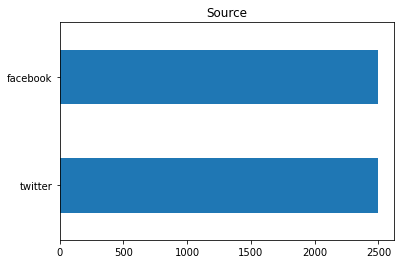

In [ ]:
df.source.value_counts().sort_values().plot(kind = 'barh', title="Source")

There are an equal number of Facebook and Twitter posts.

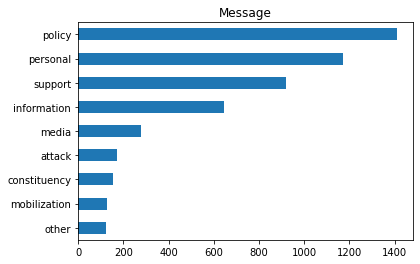

In [ ]:
df.message.value_counts().sort_values().plot(kind = 'barh', title="Message")

Most of the posts were tagged as either policy-related or personal. The least common message categories are constituency and mobilization.

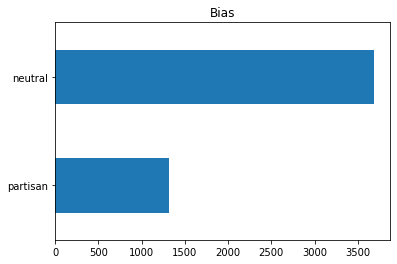

In [ ]:
df.bias.value_counts().sort_values().plot(kind = 'barh', title="Bias")

The bias column is heavily imbalanced, with nearly 3 times as many neutral posts as partisan posts. This will need to be accounted for when building a classifier.

Let's isolate the neutral and partisan posts, and print some examples of posts from each category.

In [ ]:
neutral_posts = df.text[df.bias == 'neutral']
partisan_posts = df.text[df.bias == 'partisan']

In [ ]:
for post in neutral_posts[0:5]:
    print(post)

Please join me today in remembering our fallen heroes and honoring the men and women currently in military service for their sacrifices.
RT @SenatorLeahy: 1st step toward Senate debate on Leahy-Crapo #VAWA bill is the SenateÛªs procedural vote today at 5:30 pm
@BBCWorld, help us keep the kidnapped Nigerian school girls' story out front. #BringBackOurGirls #JoinRepWilson http://t.co/ZqZVT80mga
Show your Arizona pride-choose your favorite S. AZ picture for my Facebook cover photo! Retweet to spread the word! https://t.co/7PHHigA8nd
What a wonderful night at State Senator Ken YagerÛªs Chili Supper benefitting the Boys &amp; Girls Clubs of Roane County. http://t.co/DsyoAFZvkR


In [ ]:
for post in partisan_posts[0:5]:
    print(post)

RT @nowthisnews: Rep. Trey Radel (R- #FL) slams #Obamacare. #politics https://t.co/zvywMG8yIH
VIDEO - #Obamacare:  Full of Higher Costs and Broken Promises: http://t.co/dn3vzqIrWF
.@amazon delivery #drones show need to update law to promote #innovation &amp; protect #privacy. My #UAS bill does that: http://t.co/l9ta5SKq6u
Called on the @USDOTFRA to release info about inspections before the #CasseltonDerailment to review quality of rails. (1/2)
Great op-ed by Pres. Clinton about signing #FMLA 20 yrs ago today, an important law protecting workers http://t.co/csYEv7O4 #HoyerHeadlines


Conversely, posts tagged as partisan appear to express support for specific policy and legislative issues. To better understand what types of posts were tagged as neutral and partisan, we can plot the value counts for the bias column each of the unique message types:

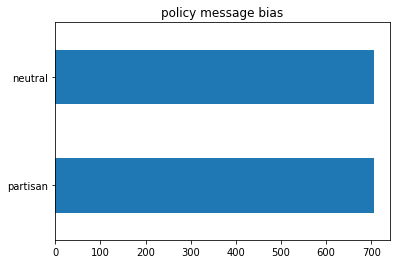

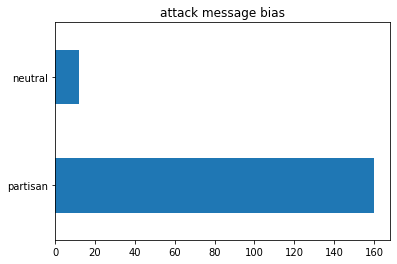

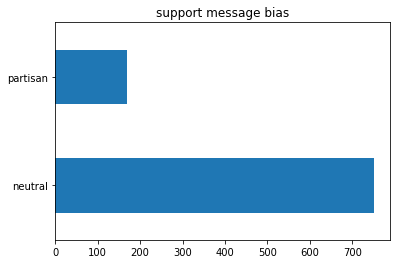

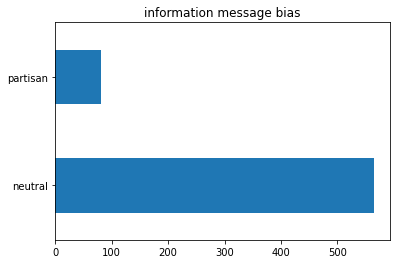

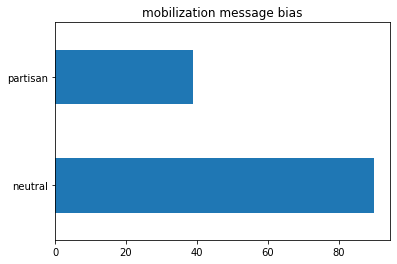

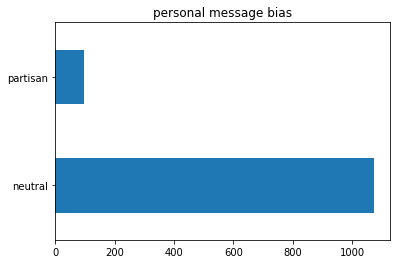

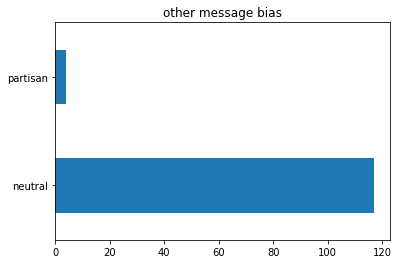

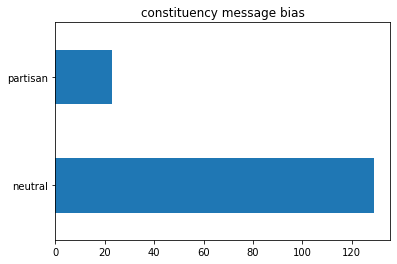

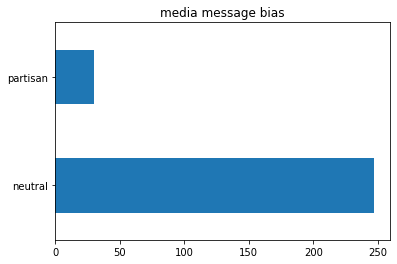

In [ ]:
for message in df.message.unique():
    bias = df.bias[df.message==message]
    bias.value_counts().plot(kind = 'barh', title="{} message bias".format(message))
    plt.show()

We can see that for every message category, with the exception of "attack" and "policy", the majority of posts were tagged as neutral.

Word Frequency

Next, let's visualize the frequency of words and word pairs for neutral and partisan posts. We'll first use the function below to clean the text in the posts.

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
stopwords_list = [stopwords.words('english')]
for w in ['http ', 'com', 'amp']:
    stopwords_list.append(w)

In [ ]:
def clean_words(text):
    
    """Takes in a string or iterable of strings, and returns a cleaned list of words in the text that was
       passed in."""
    
    #join all strings in text and separate them by white space
    joined_text = "".join(text) 
    
    #remove all characters that are not letters
    joined_text = re.sub('[^A-Za-z ]+', ' ', joined_text)
    
    #convert all words in list to their base form, or 'lemma'
    words = [WordNetLemmatizer().lemmatize(word) for word in joined_text]
    
    #create a list of individual strings for each word in the text 
    words = word_tokenize(joined_text)
    
    
    clean_words_list = []
    
    for word in words:
        
        #exclude words that don't contribute to the meaning of the text
        stopwords_list = stopwords.words('english')
        for w in ['http', 'com', 'amp', 'www']:
            stopwords_list.append(w)
        
        if len(word) > 2 and word not in stopwords_list:
            
            #populate clean words list with remaining words
            clean_words_list.append(word.lower())
    
    return clean_words_list

We'll create a clean word list for the partisan and neutral posts.

In [ ]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [ ]:

import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
clean_partisan = clean_words(partisan_posts)
clean_neutral = clean_words(neutral_posts)

NLTK's FreqDist allows us to easily create a frequency distribution for words in the text that's passed in. Below, we create frequency distributions for both classes and display the top 40 words on a line plot.

findfont: Font family ['silom'] not found. Falling back to DejaVu Sans.


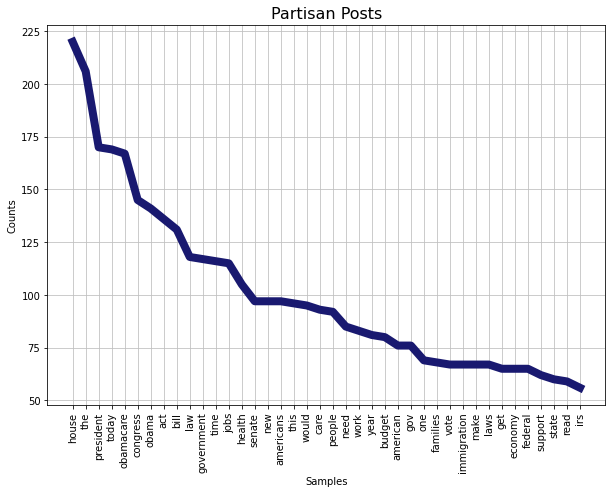

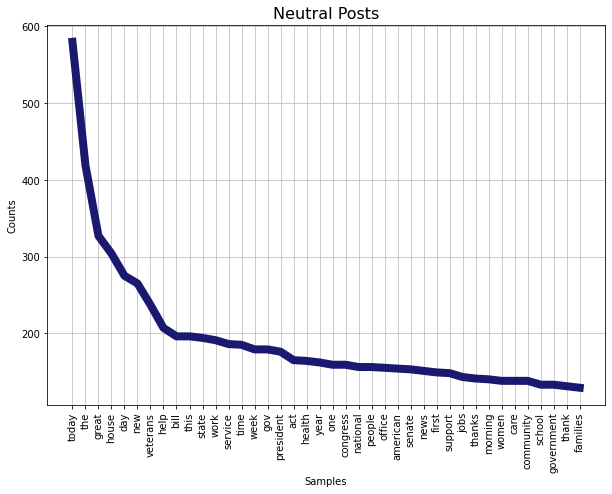

In [ ]:
partisan_freqdist = FreqDist(clean_partisan)
Neutral_freqdist = FreqDist(clean_neutral)

plt.figure(figsize=(10, 7))
plt.title('Partisan Posts', fontsize=16, fontname='silom')
partisan_freqdist.plot(40, linewidth=8, color='midnightblue') 

plt.figure(figsize=(10, 7))
plt.title('Neutral Posts', fontsize=16, fontname='silom')
Neutral_freqdist.plot(40, linewidth=8, color='midnightblue');

Wordclouds

Word clouds are another way to visualize word frequency: given a number for the top most frequent words, they display various words in a text with larger font for more frequent words.

In [ ]:
def plot_wordcloud(clean_words, name):
     
    """Takes in a clean list of words and a name for the word cloud. Returns a 25x25 word cloud 
    with the top 1000 most frequent words."""
        
    wc = WordCloud(background_color="Black", max_words=1000, max_font_size = 50)
    clean_string = ','.join(clean_words)
    wc.generate(clean_string)

    f = plt.figure(figsize=(25,25))
    plt.axis("off")
    plt.imshow(wc, interpolation='bilinear')
    plt.title('{} Word Cloud'.format(name), size=30, fontname='Silom')
    plt.axis("off")
    plt.show()

findfont: Font family ['Silom'] not found. Falling back to DejaVu Sans.


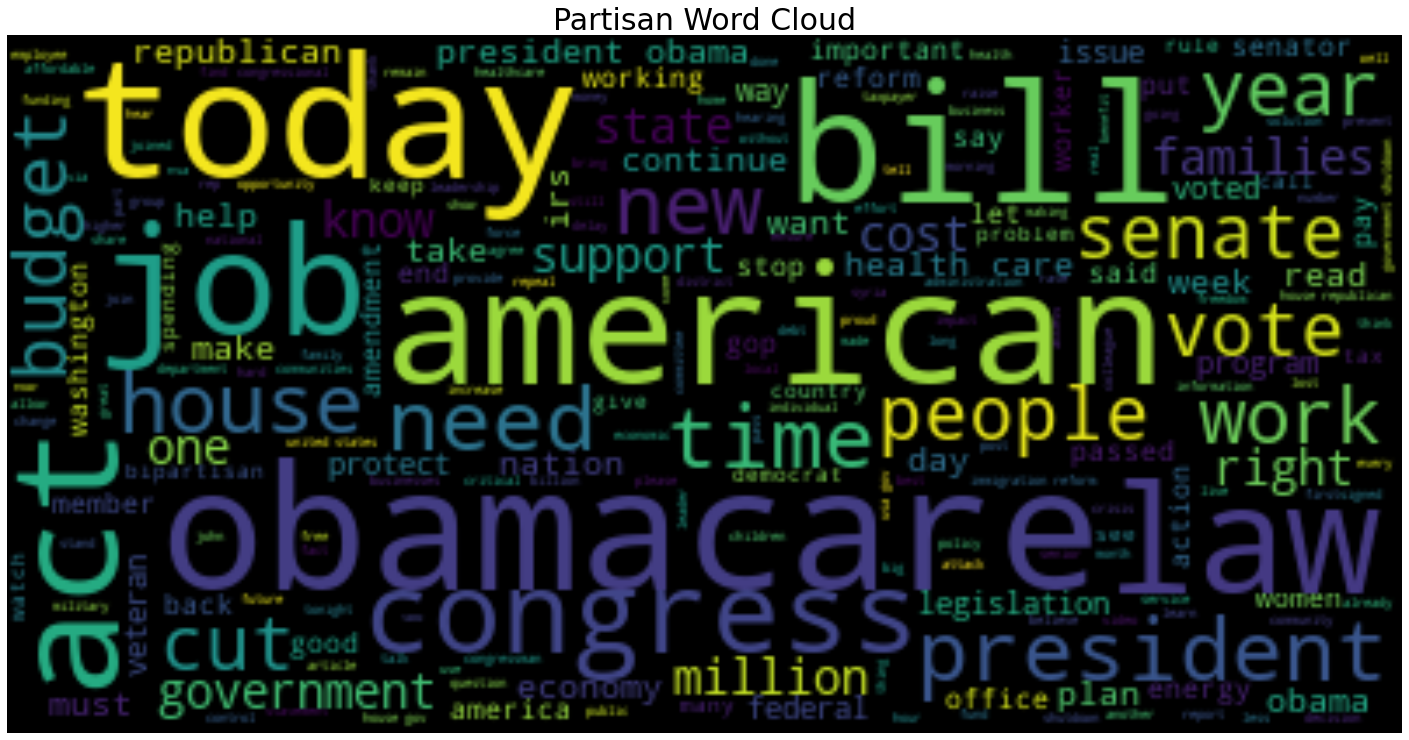

In [ ]:
plot_wordcloud(clean_partisan, "Partisan")

'Obamacare', 'bill', and 'law' stand out as some of the most prominent words.

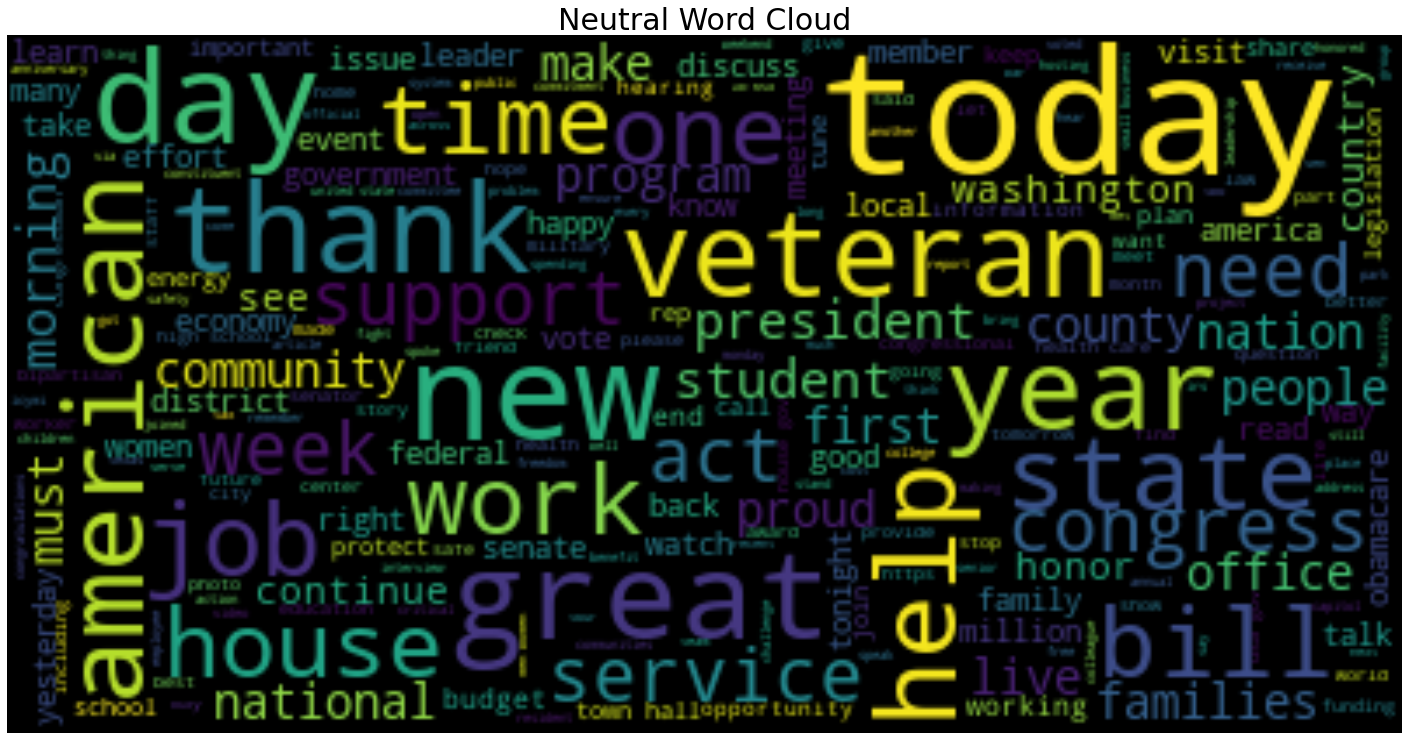

In [ ]:
plot_wordcloud(clean_neutral, "Neutral")

'Today', 'veteran', and 'american' are a few of the prominent words in the neutral post subset.

Bigrams

Now let's examine some of the most common word pairings, or bigrams. The following function will plot these pairings in an easy-to-interpret horizontal bar plot.

In [ ]:
def plot_bigrams(clean_data, data_name):
    
    """Takes in a clean list of words and a name for the Bigram plot. Returns a 10x7 bigram barplot 
       with the top 20 most frequent words."""
    
    #create list of tuples with bigrams(tuple) and their frequencies (float)
    bigram_measures = nltk.collocations.BigramAssocMeasures()
    finder = BigramCollocationFinder.from_words(clean_data)
    scored = finder.score_ngrams(bigram_measures.raw_freq)
    
    #append bigrams and their frequencies to lists for plotting
    
    bigrams = []
    freqs = []

     
    for bigram in scored[:20]:
        bigrams.append(str(bigram[0]))
        freqs.append(bigram[1])
        
    #reverse lists to display most frequent on top of barplot 
    bigrams.reverse()
    freqs.reverse()
    
    
        
    plt.figure(figsize=(10, 7))
    plt.title("{} Bigrams".format(data_name), fontname='silom', fontsize=15)
    plt.barh(bigrams, freqs, color='midnightblue')
    plt.xlabel('Frequency')
    plt.ylabel('Bigram')
    print(scored[0])

findfont: Font family ['silom'] not found. Falling back to DejaVu Sans.


(('president', 'obama'), 0.002100535998841084)


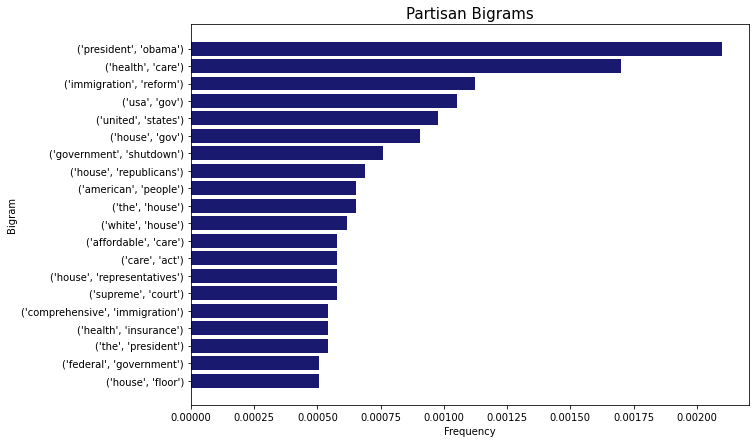

In [ ]:
plot_bigrams(clean_partisan, 'Partisan')

'President Obama', 'health care' and 'immigration reform' are among the most common partisan bigrams.

(('high', 'school'), 0.0009494985460803513)


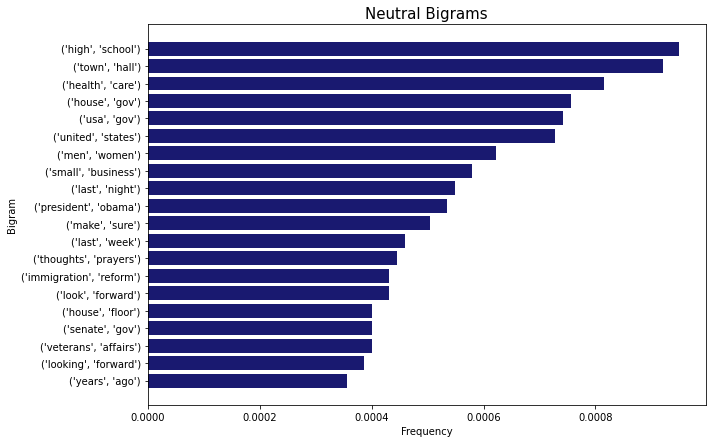

In [ ]:
plot_bigrams(clean_neutral, 'Neutral')

Common neutral bigrams include 'town hall', 'high school', and 'small business'.

Classifying Partisan Bias

To build a bias classifier, let's begin by defining x and y. We'll clean each row in the text column and append them to a new list, X:

In [ ]:
posts = []

for row in df.text:
    posts.append(clean_words(row))
    
clean_posts = [" ".join(post) for post in posts]
clean_posts[0:5]

['nowthisnews rep trey radel slams obamacare politics https zvywmg yih',
 'video obamacare full higher costs broken promises vzqirwf',
 'please join today remembering fallen heroes honoring men women currently military service sacrifices',
 'senatorleahy step toward senate debate leahy crapo vawa bill senate procedural vote today',
 'amazon delivery drones show need update law promote innovation protect privacy uas bill skq']

To convert the posts to numeric data, we'll use sklearn's TF-IDF Vectorizer. TF-IDF is a product of the following weights:

Term Frequency: Number of times a word appears in a document/total number of words in a document                                       

Inverse Document Frequency: log of total number of documents/number of documents that contain the word

In our case, a document is a social media post within the larger collection of posts in the 'text' column.

In [ ]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(clean_posts)

To numerically encode y, we'll get dummy variables for the 'bias' column and drop the neutral column. In the remaining column, 1=partisan and 0=neutral.

In [ ]:
y = pd.get_dummies(df.bias).drop('neutral', axis=1).values.ravel()

In [ ]:
display(X, y)

<5000x17013 sparse matrix of type '<class 'numpy.float64'>'
	with 87737 stored elements in Compressed Sparse Row format>

array([1, 1, 0, ..., 0, 0, 0], dtype=uint8)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 6)

Random Forest

Our first model will be a random forest classifier.

In [ ]:
rf = RandomForestClassifier(n_estimators=100)
rf.fit(X_train,y_train)

RandomForestClassifier()

The below function will allow us to easily evaluate the model's performance on both the training and test data. It plots a confusion matrix for each, as well as performance scores.

In [ ]:
def plot_cm(model, model_type, X_test, y_test, X_train, y_train, class_names):
    
    """Takes in a fitted classifier, a string for the the model type, 
       X and y training and test data, and a list of the class names. Returns a 7x5 
       confusion matrix for training and test data, with accuracy, precision, recall 
       and F1 scores plotted next to the matrices."""
    
    y_preds = model.predict(X_test)
    class_names = class_names
    fig, ax = plt.subplots(figsize=(7, 5))
    plot_confusion_matrix(model, X_test, y_test,
                                 display_labels=class_names,
                                 cmap=plt.cm.Reds, normalize='true', ax=ax)
    plt.text(x=-.5, y=-.6, s="{} Test Confusion Matrix".format(model_type), fontsize=15, fontname='silom')
    plt.text(x=2.1, y=.1, s="Accuracy: {}".format(float(round(accuracy_score(y_test, y_preds),3))), fontsize=14)
    plt.text(x=2.1, y=.3, s="Precision: {}".format(float(round(precision_score(y_test, y_preds), 3))),fontsize=14)
    plt.text(x=2.1, y=.5, s="Recall: {}".format(float(round(recall_score(y_test, y_preds), 3))),fontsize=14)
    plt.text(x=2.1, y=.7, s="F1: {}".format(float(round(f1_score(y_test, y_preds), 3))),fontsize=14)
    
    plt.show()
    
    y_preds = model.predict(X_train)
    class_names = class_names
    fig, ax = plt.subplots(figsize=(7, 5))
    plot_confusion_matrix(model, X_train, y_train,
                                 display_labels=class_names,
                                 cmap=plt.cm.Reds, normalize='true', ax=ax)
    plt.text(x=-.5, y=-.6, s="{} Training Confusion Matrix".format(model_type), fontsize=15, fontname='silom')
    plt.text(x=2.1, y=.1, s="Accuracy: {}".format(float(round(accuracy_score(y_train, y_preds),3))), fontsize=14)
    plt.text(x=2.1, y=.3, s="Precision: {}".format(float(round(precision_score(y_train, y_preds), 3))),fontsize=14)
    plt.text(x=2.1, y=.5, s="Recall: {}".format(float(round(recall_score(y_train, y_preds), 3))),fontsize=14)
    plt.text(x=2.1, y=.7, s="F1: {}".format(float(round(f1_score(y_train, y_preds), 3))),fontsize=14)
    
    plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


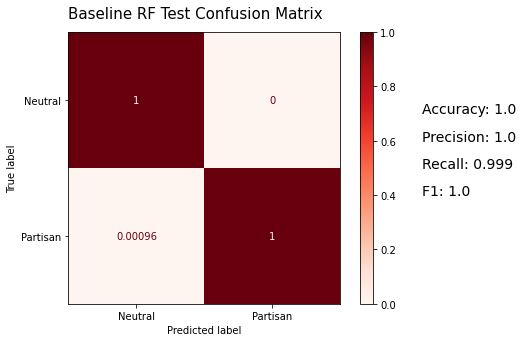

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


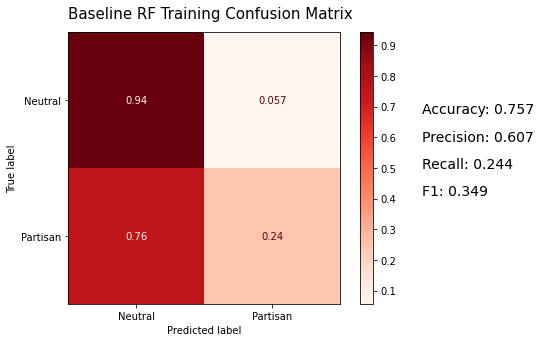

In [ ]:
plot_cm(rf, 'Baseline RF',
        X_train, y_train, 
        X_test, y_test, 
        class_names=['Neutral', 'Partisan'])

The baseline model performed poorly on the training data. We'll pass the parameter grid below into RandomizedSearchCV to choose better parameters for a random forest model. Note that the 'class weight' options are both balanced, which should correct some of the class imbalance in y.

In [ ]:
class_weight = ['balanced', 'balanced_subsample']
n_estimators = [50, 100, 150, 500, 1000]
max_features = ['auto', 'sqrt']
max_depth = [10, 50, 80, 100, 120]
min_samples_split = [2, 5, 6, 7, 10]
min_samples_leaf = [1, 2, 4, 6]
bootstrap = [True, False]
param_grid = {'class_weight' : class_weight,
               'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [ ]:
rf = RandomForestClassifier()
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = param_grid, 
                               n_iter = 10, cv = 5, random_state=6, n_jobs = -1)

In [ ]:
rf_random.fit(X_train,y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'class_weight': ['balanced',
                                                         'balanced_subsample'],
                                        'max_depth': [10, 50, 80, 100, 120],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4, 6],
                                        'min_samples_split': [2, 5, 6, 7, 10],
                                        'n_estimators': [50, 100, 150, 500,
                                                         1000]},
                   random_state=6)

We can retrieve the best-performing parameters from the search with the best_params_ attribute

In [ ]:
best_params = rf_random.best_params_
best_params

{'bootstrap': True,
 'class_weight': 'balanced',
 'max_depth': 100,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 7,
 'n_estimators': 500}

Below, we fit the best model to the training data.

In [ ]:
optimized_rf = rf_random.best_estimator_
optimized_rf.fit(X_train,y_train)

RandomForestClassifier(class_weight='balanced', max_depth=100,
                       min_samples_split=7, n_estimators=500)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


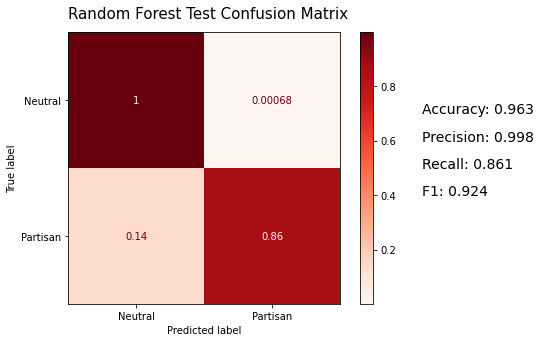

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


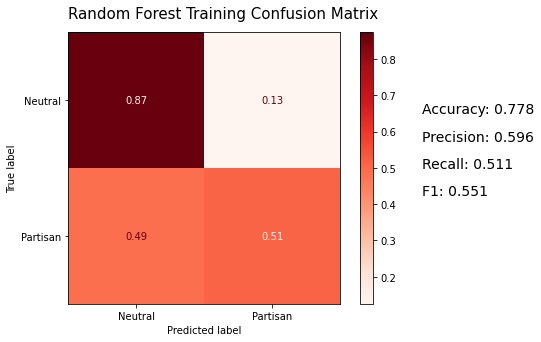

In [ ]:
plot_cm(optimized_rf, 'Random Forest',
        X_train, y_train, 
        X_test, y_test, 
        class_names=['Neutral', 'Partisan'])

The model performs well on the test data, but still fails on the training data: it is over-predicting neutral posts. This issue can be corrected by over-sampling the minority class (partisan posts) with the Synthetic Minority Oversampling Technique (SMOTE) .

In [ ]:
smote = SMOTE(random_state=6)
X, y = smote.fit_resample(X, y)

If we look at the value counts in y, we can see that there are now an equal number of '0'(neutral) and '1'(partisan') values:

In [ ]:
counter = Counter(y)
print(counter)

Counter({1: 3689, 0: 3689})


Below, we create new training and test subsets from the resampled data, and fit the random forest model to the data.

In [ ]:
SMOTE_X_train, SMOTE_X_test, SMOTE_y_train, SMOTE_y_test = train_test_split(X, y, test_size=0.2, random_state = 6)

In [ ]:
optimized_rf.fit(SMOTE_X_train, SMOTE_y_train)

RandomForestClassifier(class_weight='balanced', max_depth=100,
                       min_samples_split=7, n_estimators=500)

Let's see how the model performs on the original training and test data:

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


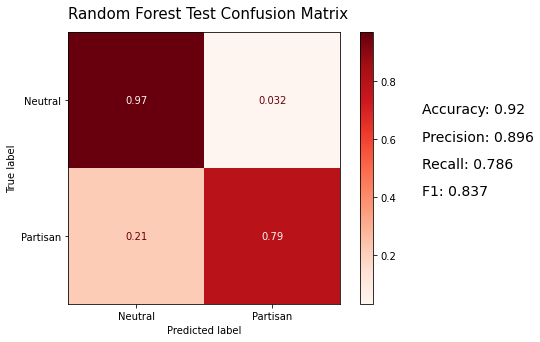

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


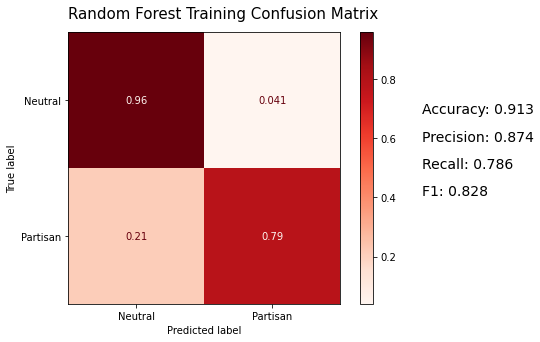

In [ ]:
plot_cm(optimized_rf, 'Random Forest',
        X_train, y_train, 
        X_test, y_test, 
        class_names=['Neutral', 'Partisan'])

The model's performance on the training data improved significantly after over-sampling the minority class: the new accuracy score for both training and test data is above .90. The recall score, or true positive rate, is much lower, which suggests that the model is still over-predicting neutral posts. It nonetheless well exceeds the performance of random guessing.

Classifying the Message of Posts

We'll define X again, and use LabelEncoder to convert values in the message column to integers:

In [ ]:
X = vectorizer.fit_transform(clean_posts)

In [ ]:
le = preprocessing.LabelEncoder()
y = pd.DataFrame(le.fit_transform(df.message)).values.ravel()

We can access the classes that have been encoded by using classes_:

In [ ]:
le.classes_

array(['attack', 'constituency', 'information', 'media', 'mobilization',
       'other', 'personal', 'policy', 'support'], dtype=object)

The first class, 'attack', in this array has been encoded as 0, 'constituency' has been encoded as 1, and so on. Below, we can see how the labels have been encoded for the first 10 posts in the data.

In [ ]:
list(zip(df.message.head(10), y[0:10]))

[('policy', 7),
 ('attack', 0),
 ('support', 8),
 ('policy', 7),
 ('policy', 7),
 ('information', 2),
 ('mobilization', 4),
 ('mobilization', 4),
 ('personal', 6),
 ('support', 8)]

K-Nearest Neighbors

We'll create a K-Nearest Neighbors (KNN) model to predict the posts' message. Since the message column also has highly imbalanced classes, we'll resample the data again using SMOTE, and split it into training and test sets:

In [ ]:
X, y = smote.fit_resample(X, y)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 9)

KNN is an algorithm that makes predictions based on the distance between a value in X and other X-values. It assumes that highly proximate values will be members of the same class.

In [ ]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)

KNeighborsClassifier()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
findfont: Font family ['silom'] not found. Falling back to DejaVu Sans.


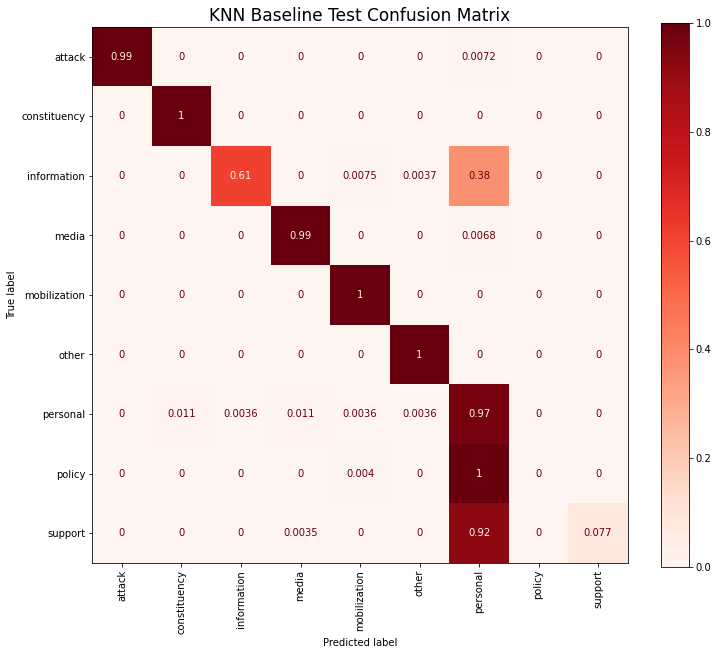

In [ ]:
fig, ax = plt.subplots(figsize=(12, 10))
plot_confusion_matrix(knn, X_test, y_test,
                      display_labels=list(le.classes_),
                      cmap=plt.cm.Reds, xticks_rotation='vertical', normalize='true', ax=ax)
plt.title('KNN Baseline Test Confusion Matrix', fontname='silom', fontsize=17)
plt.show()

In [ ]:
accuracy_score(knn.predict(X_test), y_test)

0.7515748031496063

The baseline model predicted posts of certain classes with high accuracy, but performed poorly on others. The overall accuracy was .75, which can likely be improved. Using an exhaustive grid search, we'll tune the following parameters:

N-Neighbors: Number of neighbors (close values)         
p: distance metric (Euclidean vs. Manhattan)

In [ ]:
n_neighbors = [1, 2, 3, 5, 10, 15]
p=[1,2]

param_grid = {'n_neighbors': n_neighbors, 
              'p': p}

knn = KNeighborsClassifier()
knn_grid = GridSearchCV(knn, param_grid, cv=4)

In [ ]:
#fit the best estimator to the data
optimized_knn = knn_grid.fit(X_train, y_train)

In [ ]:
#look at the best parameters
knn_grid.best_params_

{'n_neighbors': 1, 'p': 2}

In [ ]:
#training accuracy
y_train_preds = optimized_knn.predict(X_train)
accuracy_score(y_train_preds, y_train)

0.9998031302293533

The model had a near-perfect accuracy score for the training data.

In [ ]:
#test accuracy
y_test_preds = optimized_knn.predict(X_test)
accuracy_score(y_test_preds, y_test)

0.8759842519685039

The accuracy score on the test data was .87, which is much better than the baseline model. In a dataset with balanced classes, there would be about a .11 accuracy rate with random guessing. Let's plot a confusion matrix to see how the test predictions compare to the true test labels.

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


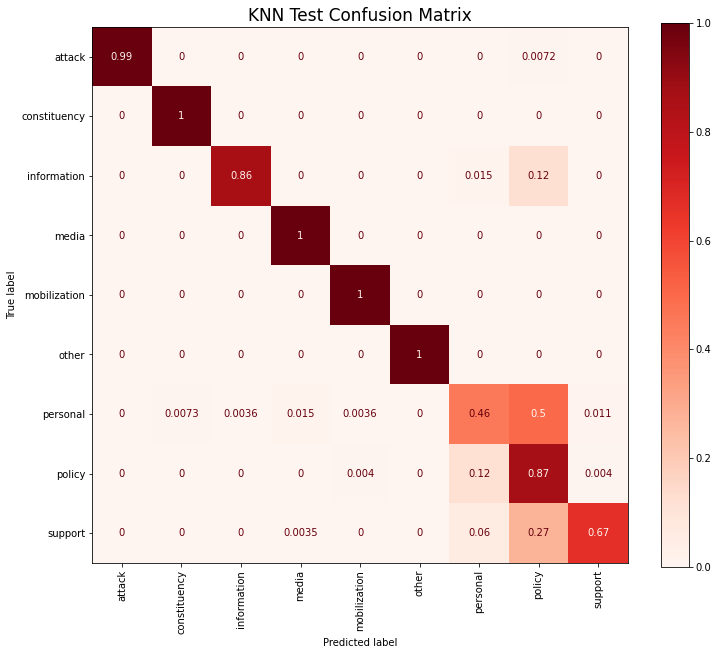

In [ ]:
fig, ax = plt.subplots(figsize=(12, 10))
plot_confusion_matrix(optimized_knn, X_test, y_test,
                                display_labels=list(le.classes_),
                                cmap=plt.cm.Reds, xticks_rotation='vertical', normalize='true', ax=ax)
plt.title('KNN Test Confusion Matrix', fontname='silom', fontsize=17)
plt.show()

The model perfectly or near-perfectly predicted most classes. However, the model misclassified about half of personal posts, and 27% of support posts, as policy posts.

The model's predictions on the training data, unsurprisingly, had even higher accuracy:

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


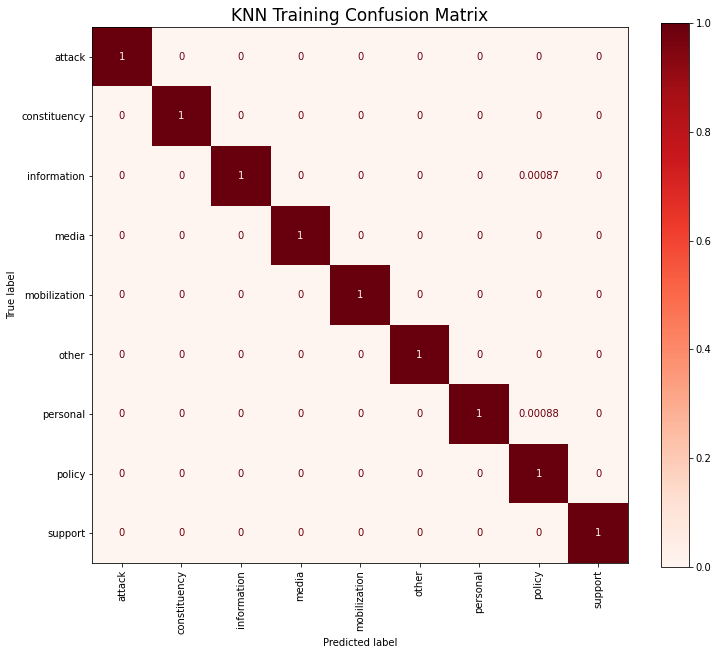

In [ ]:
fig, ax = plt.subplots(figsize=(12, 10))
plot_confusion_matrix(optimized_knn, X_train, y_train,
                                display_labels=list(le.classes_),
                                cmap=plt.cm.Reds, xticks_rotation='vertical', normalize='true', ax=ax)
plt.title('KNN Training Confusion Matrix', fontname='silom', fontsize=17)
plt.show()

Making Predictions on New Data

Retrieving the Tweets

Using Twitter's API and Tweepy, we can generate a new sample of Tweets from politicians. The function below retrieves up to 30 recent Tweets and returns them as a list of strings.

Note: for the below code to work properly in reproduction, a unique consumer key and secret will need to be passed into the "auth" object. Tweepy's Authentication Tutorial may be consulted for futher details.

In [ ]:
auth = tweepy.OAuthHandler('qfZqjjdtYKzpwSsoj75jDHnvK',
                           'nK8Z1vJy3PcpXUwFBEEgKaKpRlr2Y7jAfPQKJGPtnYAflFQEp2')
api = tweepy.API(auth)

In [ ]:
def get_100_tweets(username): 
    
    """Takes in a Twitter username. Returns up to 100 Tweets after Twitter api is defined as 'api'."""
    
    tweets = api.user_timeline(screen_name=username, count=100, tweet_mode="extended", lang="en")
    
    tweets_list = []
    
    tweets = [tweet.full_text for tweet in tweets]
    
    for tweet in tweets:
        if not tweet[:1].startswith("@") and 'https' not in tweet:
            tweets_list.append(tweet)
            
    return tweets_list

Let's get Tweets from the accounts of two politicians who are on many Americans' minds this election season: Donald Trump and Joe Biden.

In [ ]:
DT_Tweets = get_100_tweets('POTUS')

In [ ]:
JB_Tweets = get_100_tweets('JoeBiden')

Predictions Example: Joe Biden

We'll process the Joe Biden Tweets in the same way as the posts from the original dataframe. The function below creates a new dataframe with the Tweets and predicted values for bias and message.

In [ ]:
def predict_tweets(Tweets):
    
    """Takes in a list of Tweets, cleans them, and uses the optimized_knn and optimized_rf models
       to predict the message and bias of Tweets, respectively. Returns a dataframe with the original 
       Tweets and corresponding predictions."""
    
    clean = []
    
    for tweet in Tweets:
        clean.append(clean_words(tweet))
        
    clean = [" ".join(post) for post in clean]
        
    X = vectorizer.transform(clean)

    message_preds = optimized_knn.predict(X)
    bias_preds = optimized_rf.predict(X)
    
    df = pd.DataFrame({'Tweet': Tweets, 'Partisan Bias': bias_preds, 'Message': message_preds})
    
    return df

In [ ]:
#create dataframe with JB Tweets and predictions
JB_df = predict_tweets(JB_Tweets)

Now let's isolate some predicted partisan Tweets in JB_df and print them:

In [ ]:
print('Joe Biden Partisan Tweets:')
print('')
for i in JB_df[JB_df['Partisan Bias'] == 1].Tweet[0:5]: #Tweet rows in JB_df where Partisan Bias = 1 (partisan)
    print(i)

Joe Biden Partisan Tweets:

High-speed internet is not a luxury any longer. It's a necessity. 

That's why the Bipartisan Infrastructure Law included $65 billion to make sure we expand access to broadband internet in every region of the country—urban, suburban, and rural.
There have been only 3 months in the last 50 years where the unemployment rate in America is lower than it is now. 

This is a direct result of the American Rescue Plan, our COVID vaccination program, and my plan to grow our economy from the bottom up and middle out.
The Republican plan led by Senator Rick Scott of Florida would tax half of our small business owners an extra $1,200 a year on average.

My plan would make it easier to start a small business by expanding their access to capital.
Today, we learned that the economy created 428,000 jobs in April—bringing the total number of jobs created since I took office to 8.3 million.

There's more work to do, but our plans and policies have produced the strongest job c

Phrases like 'proud Democrat', and 'most corrupt' definitely signal partisan views. In most of these Tweets, Biden is either making political promises for his own potential presidency, or criticizing the performance of the Trump administration. Overall, these classifications appear to be accurate. What about neutral Tweets? Below, we print the first five.

In [ ]:
print('Joe Biden Neutral Tweets:')
print('')
for i in JB_df[JB_df['Partisan Bias'] == 0].Tweet[0:5]: #Tweet rows in JB_df where Partisan Bias = 0 (neutral)
    print(i)

Joe Biden Neutral Tweets:

I encourage Congressional Republicans to join us in our efforts to lower prices for families across the country, by making more in America, strengthening our supply chains, and cutting energy and prescription drug costs.
RT @POTUS: Happy Mother’s Day, @FLOTUS. You’re the love of my life and the life of my love. You bring me joy and laughter every day, and I’…
When I took office, there were around 20 million people relying on unemployment benefits to feed their families; today, that number is around 1 million—the lowest since 1970. 

We are building an economy that values the dignity of work.
RT @POTUS: Today, I met with grassroots worker organizers to thank them for their leadership in organizing unions. From the Amazon Labor Un…
RT @POTUS: Jill and I extend our warmest wishes to all who are celebrating Eid al-Fitr. As Muslims around the world conclude the month of R…


In the above text, Biden is referring to 'democracy' and 'the American people', largely urging patience throughout the vote counting process. His message is an attempt to unify the country during an otherwise highly divisive election. These classifications also appear to be accurate.

To test the message classification model, let's print the Tweets that were classified as personal.

In [ ]:
print('Joe Biden Support Tweets:')
print('')
for i in JB_df[JB_df['Message'] == 1].Tweet: #Tweet rows in JB_df where Message = 1 (support)
    print(i)

Joe Biden Support Tweets:



In this Tweet, Joe Biden is reassuring Americans that votes will be counted, and encouraging them to vote. This encouragement, if correctly classified as "support", is supportive of American voters who have concerns about potential interference in the democratic process.

Predictions Example: Donald Trump

In [ ]:
DT_df = predict_tweets(DT_Tweets)

What are some examples of Tweets that were classified as partisan?

In [ ]:
print('Donald Trump Partisan Tweets:')
print('')
for i in DT_df[DT_df['Partisan Bias'] == 1].Tweet[0:5]:
    print(i)

Donald Trump Partisan Tweets:

I happen to think it’s a good thing when American families have more money in their pockets at the end of the month. 

But Republicans in Congress don’t seem to think so. Their plan is going to make working families poorer.
The ultra-MAGA plan put forward by Congressional Republicans will:

- Raise taxes on working families
- Lower the incomes of workers
- Threaten Social Security, Medicare, and Medicaid
- Give big corporations and billionaires break after break
My plan attacks inflation and grows our economy by:
 
- Lowering costs for working families
- Giving workers a well-deserved raise
- Reducing the deficit by historic levels
- Making big corporations and the wealthiest Americans pay their fair share
I’ve proposed a minimum tax for billionaires.
 
Congressional Republicans have proposed increasing taxes on teachers and firefighters.
The Congressional Republican plan will raise taxes on 75 million American families — over 95% of whom earn less than $

Here again, Trump is making political promises and criticizing his political opponents. All of the above classifications could be considered accurate. Let's now look at some of the neautral Tweets.

In [ ]:
print('Donald Trump Neutral Tweets:')
print('')
for i in DT_df[DT_df['Partisan Bias'] == 0].Tweet[0:5]:
    print(i)

Donald Trump Neutral Tweets:

The bottom line is this: There are two paths, reflecting two very different sets of values.
RT @WhiteHouse: President Biden’s plan to tackle inflation will help give working families a little more breathing room and ensure the weal…
This afternoon, I’m hosting a bilateral meeting with Prime Minister Mario Draghi of Italy at the White House. I look forward to reaffirming the friendship and strong partnership between our two nations and discussing our ongoing support for Ukraine.
Today’s jobs report shows our plans and policies have produced the strongest job creation economy in modern times. 
 
8.3 million jobs in my first 15 months in office.
We’re launching a new compact between large iconic manufacturers and smaller American suppliers to help them adopt new technologies.
 
And as part of this initiative, agencies across the federal government will step up with access to loans, technical assistance, and more.


Let's look at some of the Tweets that were classified as policy-related.

In [ ]:
print('Donald Trump Policy Tweets:')
print('')
for i in DT_df[DT_df['Message'] == 7].Tweet[0:5]:
    print(i)

Donald Trump Policy Tweets:

I happen to think it’s a good thing when American families have more money in their pockets at the end of the month. 

But Republicans in Congress don’t seem to think so. Their plan is going to make working families poorer.
The ultra-MAGA plan put forward by Congressional Republicans will:

- Raise taxes on working families
- Lower the incomes of workers
- Threaten Social Security, Medicare, and Medicaid
- Give big corporations and billionaires break after break
My plan attacks inflation and grows our economy by:
 
- Lowering costs for working families
- Giving workers a well-deserved raise
- Reducing the deficit by historic levels
- Making big corporations and the wealthiest Americans pay their fair share
The bottom line is this: There are two paths, reflecting two very different sets of values.
RT @WhiteHouse: President Biden’s plan to tackle inflation will help give working families a little more breathing room and ensure the weal…


Conclusions and Recommendations

The random forest model can be used to predict whether a social media post is partisan or neutral with high accuracy. After collecting Tweets or other social media posts for more recent data, partisan posts can be identified and extracted for review by constituents or organizations interested in learning more about a particular politician’s views.

The KNN model can classify the message of a post with significantly higher accuracy than random guessing, and performs particularly well on the following classes: attack, constituency, media, mobilization, and ‘other’. The exploratory analysis suggested that posts perceived as partisan tend to contain words/word pairings related to specific policy or legislative issues, like ‘law’, ‘health care,’ and ‘immigration reform.’ These terms can be used in queries when attempting to collect partisan posts.

Given the age of this data, and the dynamic nature of political discourse, more recent labeled data of a similar type could support the development of classifiers with higher accuracy on new posts.